In [1]:
import  numpy               as     np
from    astropy.table       import Table
from    astropy.io          import fits
from    astropy.coordinates import SkyCoord
import  astropy.units       as     u 

import  matplotlib.pyplot   as     plt
import  matplotlib.colors   as     colors 

## preparing 3dhst & JWST catalog

In [2]:
#3d hst
cat_obj_lis = Table.read('data_3dhst/3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat.FITS')


#jwst data
obj_lis = Table.read('spectra-fitting_selected_psfmatched.fits')
obj_lis = obj_lis#[obj_lis['field']=='uma-03']

### plot what all the fields look like

Text(0, 0.5, 'dec [deg]')

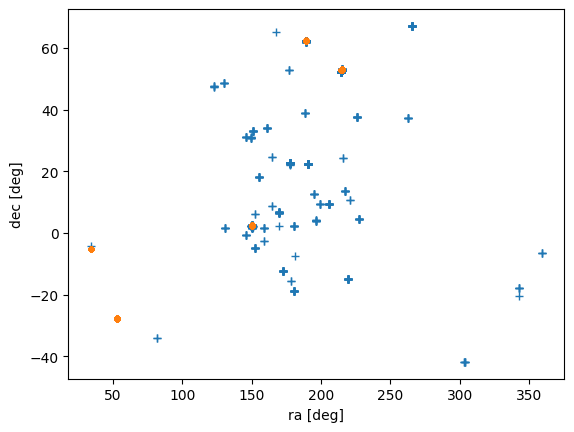

In [13]:
%matplotlib inline
plt.plot(obj_lis['ra'],obj_lis['dec'],linewidth=0,marker='+')
cat_obj_lis = Table.read('data_3dhst/3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat.FITS')
plt.plot(cat_obj_lis ['ra'],cat_obj_lis['dec'],linewidth=0,marker='.')
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')


# catalog crossmatching

(<Column name='field' dtype='bytes7' length=3>
  AEGIS
 COSMOS
GOODS-N, array([ 1, 23, 33]))


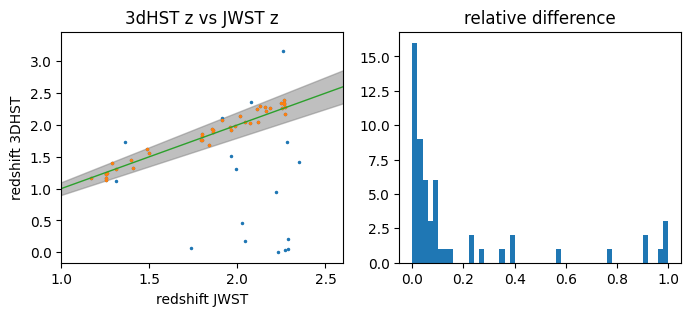

total number of objects: 692
number of matched objects: 57
number of object within 10.0% rel. error: 40
median of rel. difference: 0.05538390195977031


In [111]:
#catalog crossmatching, 
# 3DHST catalog from https://archive.stsci.edu/prepds/3d-hst/
# JWST  catalog from OUTThere and processed in previous segments.
# here 2d crossmatch is performed, 
# rule of successful crossmatch: 
#   d2d < accept_value
#further selection rule:
#   redshift rel. difference < accecpt_value%
jwst_objs = SkyCoord(ra = obj_lis['ra']*u.degree,dec=obj_lis['dec']*u.degree)
hst_objs = SkyCoord(ra = cat_obj_lis['ra']*u.degree,dec=cat_obj_lis['dec']*u.degree)
idx, d2d, d3d = jwst_objs.match_to_catalog_sky(hst_objs)


#check the properties of my crossmatch:
#  matched fields & num of objects
%matplotlib inline
match_rule = d2d.to(u.deg).value < 0.1/3600
cat_obj_matched = cat_obj_lis[idx][match_rule]
obj_matched     = obj_lis[match_rule]
print(np.unique(cat_obj_matched['field'],return_counts=True))

#plt.plot(cat_obj_matched['ra'],cat_obj_matched['dec'],linewidth=0,alpha=0.5,marker='.')
#plt.plot(obj_matched['ra'],obj_matched['dec'],linewidth=0,alpha=0.5,marker='+')



#here check the redshift of 2 catalogs & the 2nd selection rule of rel. difference in redshift
cat_z = np.where(cat_obj_matched['z_spec']!=-1,
                 cat_obj_matched['z_spec'],
                 cat_obj_matched['z_peak'])
rel_diff = np.abs(cat_z-obj_matched['redshift'])/obj_matched['redshift']#cat_obj_matched['z_peak']
accept= 0.1
select =  np.abs(rel_diff)<accept


#---------------------------plot-------------------------------------
ax = plt.figure(figsize=(8,3))
ax.add_subplot(121)
#plots redshift jwst vs redshif hst
plt.plot(obj_matched['redshift'],
         cat_z,linewidth=0,
         marker='.',markersize=3)
plt.plot(obj_matched['redshift'][select],
         cat_z[select],
         linewidth=0,marker='.',markersize=3)

#the y =x line
x = np.linspace(0,3,10)
x_lo=x*(1-accept);x_up=x*(1+accept)
plt.plot(x,x,linewidth=1)
plt.fill_between(x, x_lo, x_up, color="gray", alpha=0.5, label="10% Error")  # 灰色误差区间
plt.xlabel('redshift JWST');plt.ylabel('redshift 3DHST')
plt.xlim(1.0,2.6)
plt.title('3dHST z vs JWST z')

ax.add_subplot(122)
#rel. difference
plt.hist(rel_diff,bins=50)
plt.title('relative difference')
plt.show()

# print some useful info
print('total number of objects:',len(obj_lis))
print('number of matched objects:',len(obj_matched))
print(f'number of object within {accept*100}% rel. error:',len(obj_matched[select]))
print('median of rel. difference:',np.median(rel_diff))

#save the crossmatch catalog into one fits list
cross_match = fits.HDUList()
cross_match.append(fits.BinTableHDU(obj_matched[select],name='JWST_CROSSMATCH'))
cross_match.append(fits.BinTableHDU(cat_obj_matched[select],name='3DHST_CROSSMATCH'))
cross_match.writeto('JWST_HST_catalog_crossmatched.fits',overwrite=True)

#### the following is the SFMS model from [Whitaker 2014](https://iopscience.iop.org/article/10.1088/0004-637X/795/2/104/pdfhttps://iopscience.iop.org/article/10.1088/0004-637X/795/2/104/pdf)

In [86]:
#the following is the SFMS model from 
# eq.2 & table 3 of Whitaker 2014
def z_10_15(m_array):
    sfr = np.zeros(len(m_array))
    sfr_err = np.zeros(len(m_array))
    lowmass = m_array<10.2
    sfr[lowmass]     = 0.99 * (m_array[lowmass]-10.2) + 1.31 
    sfr_err[lowmass] = np.sqrt((0.04*(m_array[lowmass]-10))**2 + 0.02**2)
    highmass = m_array >= 10.2  
    sfr[highmass]     = 0.51 * (m_array[highmass]-10.2) + 1.31
    sfr_err[highmass] = np.sqrt((0.07*(m_array[highmass]-10))**2 + 0.02**2)
    return sfr,sfr_err

def z_20_25(m_array):
    sfr = np.zeros(len(m_array))
    sfr_err = np.zeros(len(m_array))
    lowmass = m_array<10.2
    sfr[lowmass]     = 0.91 * (m_array[lowmass]-10.2) + 1.62
    sfr_err[lowmass] = np.sqrt((0.06*(m_array[lowmass]-10))**2 + 0.02**2)
    highmass = m_array >= 10.2  
    sfr[highmass]     = 0.67 * (m_array[highmass]-10.2) + 1.62
    sfr_err[highmass] = np.sqrt((0.06*(m_array[highmass]-10))**2 + 0.02**2)
    return sfr,sfr_err

def SFMS_model(m_min,m_max):
    m = np.linspace(m_min,m_max,30)
    sfr_1_l = z_10_15(m)[0] - z_10_15(m)[1]
    sfr_1_h = z_10_15(m)[0] + z_10_15(m)[1]
    sfr_2_l = z_20_25(m)[0] - z_20_25(m)[1]
    sfr_2_h = z_20_25(m)[0] + z_20_25(m)[1]
    return m, sfr_1_l, sfr_1_h, sfr_2_l, sfr_2_h

### read SFR catalog & SFMS

/tmp/ipykernel_113161/3874567270.py:18: RuntimeWarning: invalid value encountered in log10
  np.log10(cat_obj_matched['sfr'][low_redshift]),
/tmp/ipykernel_113161/3874567270.py:21: RuntimeWarning: invalid value encountered in log10
  np.log10(cat_obj_matched['sfr'][high_redshift]),


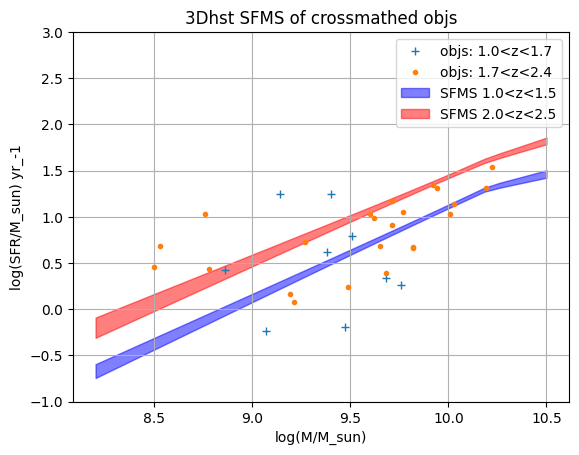

In [113]:
#read SFR from SFR catalog of individual fields,
#data available at https://archive.stsci.edu/prepds/3d-hst/
sfr_field_name={'AEGIS':'aegis','COSMOS':'cosmos','GOODS-N':'goodsn'}
sfr_lis = []
for obj in cat_obj_matched:
    sfr_file = np.loadtxt(f"data_3dhst/sfr_3dhst.v4.1/{sfr_field_name[obj['field']]}_3dhst.v4.1.sfr")
    sfr_lis.append(sfr_file[sfr_file[:,0]==obj['id']][0][2])
sfr_lis = np.array(sfr_lis)
cat_obj_matched['sfr'] = sfr_lis

#seperate low,high
select =  np.abs(rel_diff)<accept
low_redshift = np.logical_and(obj_matched['redshift']<1.6,select)
high_redshift   = np.logical_and(obj_matched['redshift']>1.6,select)


plt.plot(cat_obj_matched['lmass'][low_redshift],
         np.log10(cat_obj_matched['sfr'][low_redshift]),
         linewidth=0,marker='+',label='objs: 1.0<z<1.7')
plt.plot(cat_obj_matched['lmass'][high_redshift],
         np.log10(cat_obj_matched['sfr'][high_redshift]),
         linewidth=0,marker='.',label='objs: 1.7<z<2.4')
m, sfr_1_l, sfr_1_h, sfr_2_l, sfr_2_h = SFMS_model(8.2,10.5)
plt.fill_between(m, sfr_1_l,sfr_1_h, 
                 color="b", alpha=0.5,label='SFMS 1.0<z<1.5') 
plt.fill_between(m, sfr_2_l,sfr_2_h, 
                 color="r", alpha=0.5,label='SFMS 2.0<z<2.5')

plt.ylim(-1,3)
plt.xlabel('log(M/M_sun)')
plt.ylabel('log(SFR/M_sun) yr_-1')
plt.grid()
plt.title('3Dhst SFMS of crossmathed objs')
plt.legend()
plt.show()
